

# Laboratory work. Timeseries forecasting.

*Maslov Aleksandr* <br/>*Group 5197*




## Task 1
Make a primary analysis of the data _"E_RRC_SETUP_FR_LTE"_  and to visualize the time series with help of _matplotlib_ or _seaborn_. Visualize a slice of data over a short period of time. Make a histogram of considered data. Build a box-plot of the data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
KPI = "E_RRC_SETUP_FR"
data = pd.read_excel('E_RRC_SETUP_FR_LTE.xlsx',
                     skiprows=0,
                     usecols='A:B')
data['DT'] = data['DT'].ffill()
data['E_RRC_SETUP_FR'] = data['E_RRC_SETUP_FR'].ffill()
data[:10]
data['month'] = pd.DatetimeIndex(data['DT']).month

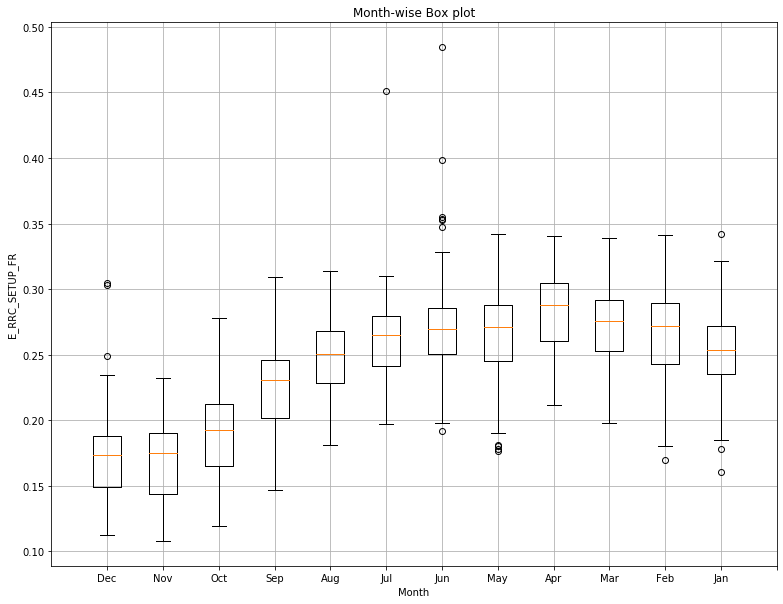

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([(data.loc[data['month'] == 12])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 11])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 10])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 9])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 8])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 7])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 6])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 5])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 4])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 3])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 2])['E_RRC_SETUP_FR'],
            (data.loc[data['month'] == 1])['E_RRC_SETUP_FR']],
            labels=['Dec', 'Nov', 'Oct', 'Sep', 'Aug', 'Jul','Jun', 'May', 'Apr', 'Mar', 'Feb', 'Jan'], vert=True)
fig.set_figwidth(13)    
fig.set_figheight(10)
plt.xticks(np.linspace(1,13,13))
plt.xlim([0,13])
plt.xlabel("Month")
plt.ylabel("E_RRC_SETUP_FR")
plt.title("Month-wise Box plot")
plt.grid()
plt.show()

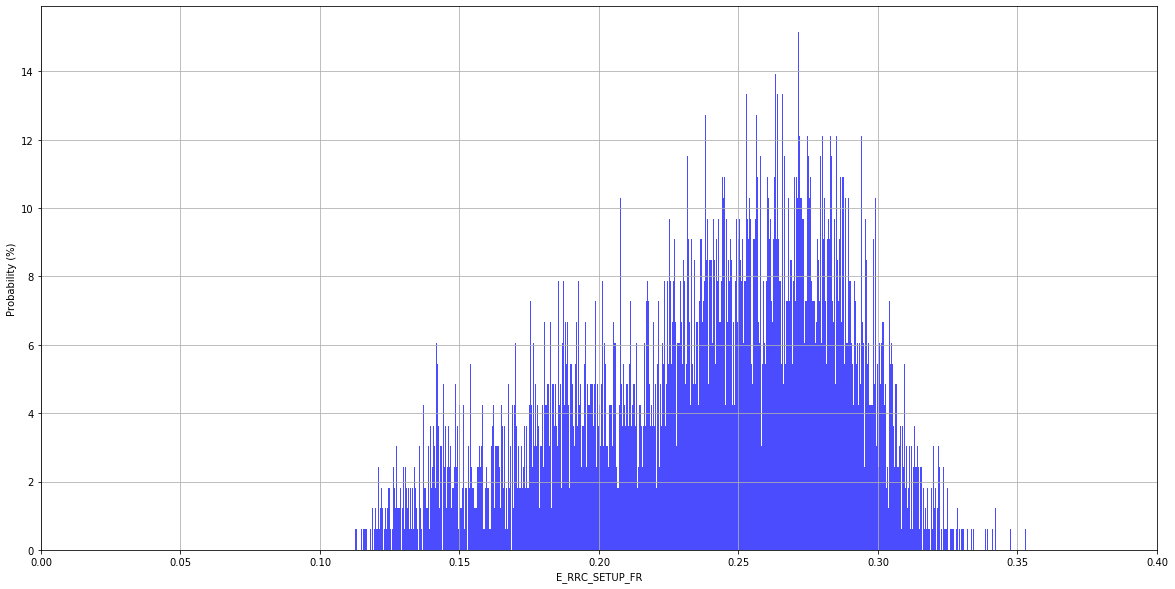

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(data["E_RRC_SETUP_FR"], 2000, density=True, facecolor='b', alpha=0.7)
plt.grid()
plt.xlabel('E_RRC_SETUP_FR')
plt.ylabel('Probability (%)')
plt.xlim([0,0.4])
fig.set_figwidth(20)
fig.set_figheight(10)
plt.show()

In [5]:
data['E_RRC_SETUP_FR'].describe()

count    8761.000000
mean        0.239066
std         0.047830
min         0.107856
25%         0.204716
50%         0.247050
75%         0.276292
max         0.484687
Name: E_RRC_SETUP_FR, dtype: float64

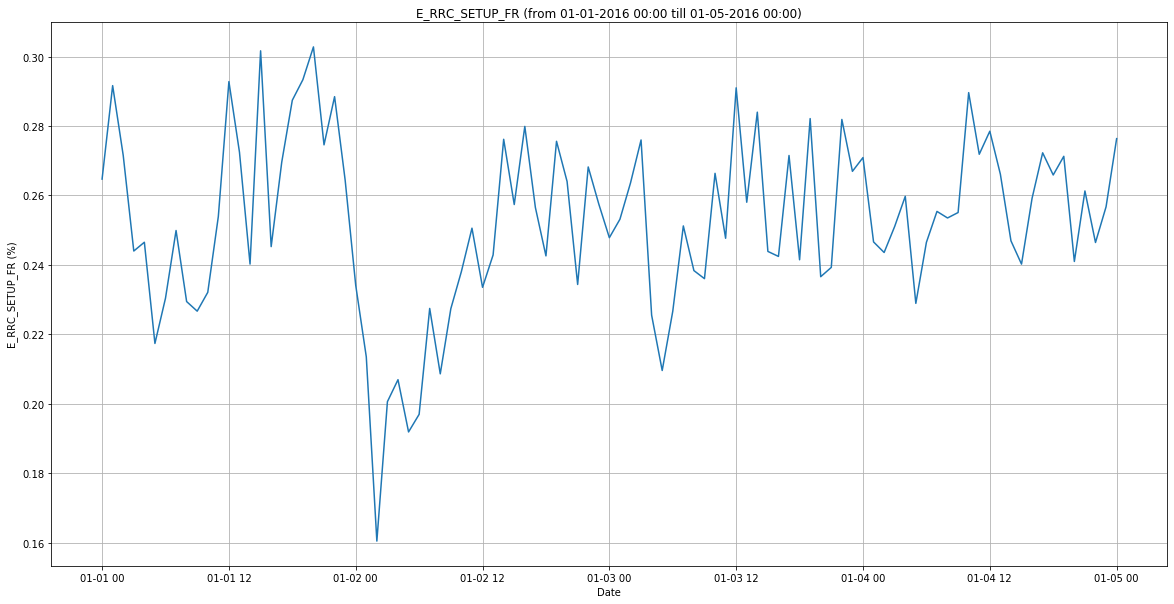

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(data["DT"][0:97], data["E_RRC_SETUP_FR"][0:97])
plt.grid()
plt.xlabel('Date')
plt.ylabel('E_RRC_SETUP_FR (%)')
plt.title('E_RRC_SETUP_FR (from 01-01-2016 00:00 till 01-05-2016 00:00)')
fig.set_figwidth(20)    
fig.set_figheight(10)
plt.show()

## Task 2
For second task it is needs to be used Holt-Winter's method and XGboost for time series forecasting.
So, we will do several preparations for this, exactly, define features and special class for models.
We using sklearn library calculate time series cross-validation: calculate mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), median absolute error (Median AE) for HW and XGboost.

In [11]:

!pip install xgboost==1.6.1
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor, plot_importance
def create_features(data, label=None):
    
    """
    Creates time series features from datetime index.
    
    Parameters
    ----------
    df: pandas.DataFrame
        Input data frame.
    label: str (default None)
        Name of the considered KPI.

    Returns
    -------
    pandas.DataFrame
        Output data frame.
    """
    
    new_df = data.copy()
    new_df.index = data["DT"]
    new_df['date'] = new_df.index
    new_df['hour'] = new_df['date'].dt.hour
    new_df['day_of_year'] = new_df['date'].dt.dayofyear

    X = new_df[['hour', 'day_of_year']]

    #new_df['day_of_week'] = new_df['date'].dt.dayofweek
    #new_df['quarter'] = new_df['date'].dt.quarter
    #new_df['month'] = new_df['date'].dt.month
    #new_df['day_of_month'] = new_df['date'].dt.day
    #new_df['week_of_year'] = new_df['date'].dt.isocalendar().week
    
    #X = new_df[['hour','day_of_week','quarter','month',
    #       'day_of_year','day_of_month','week_of_year']]
        
    if label:
        y = data[label]
        return X, y
    return X
class ModelTrainer:
    """
    Class for models training automatization.

    Attributes
    ----------
    model_type: str
    One of the available models name or abrivation:
      - 'HW' (Holt-Winters model)
      - 'SARIMA'
      - 'SARIMAX'
      - 'SARIMA (Kalman)'
      - 'SARIMAX (Kalman)'
      - 'DLM' (Dynamical Linear Models)
      - 'SVR'
      - 'XGboost'
    """
    def __init__(self, 
                model_type, 
                scale_target=False):
      
      self.model_type = model_type

    @staticmethod
    def __holt_winters_fp(y_train, X_test, **model_kwargs):
        """ Holt-Winter's method (triple exponential smoothing) """

        old_index = X_test.index
        X_test.reset_index(inplace=True)

        seasonal_periods = model_kwargs.get("seasonal_periods", 24)
        model = ExponentialSmoothing(y_train,
                                     trend="add",
                                     seasonal="add", 
                                     seasonal_periods=seasonal_periods).fit()

        predictions = model.predict(start=X_test.index[0], end=X_test.index[-1])
        X_test.set_index(old_index, inplace=True)
        return predictions

    
    def fit_predict(self, 
                  y_train,
                  X_test, 
                  X_train=None,
                  **model_kwargs):

        """ 
        Fits the model and predicts the values 

        Parameters
        ----------

        y_train: 1-D array
          Training target vector.

        X_test: 2-D array
          Testing features matrix.

        X_test: 2-D array
          Training features matrix.

        Returns
        -------

        predictions: 1-D array
          Predicted values.

        """


        if self.model_type == "HW":
            predictions = self.__holt_winters_fp(y_train, 
                                               X_test, 
                                               **model_kwargs)

       
        elif self.model_type == "XGBoost":
            model = XGBRegressor(n_estimators=1000).fit(X_train, y_train)
            predictions = model.predict(X_test)

        return predictions

    

from sklearn.metrics import (mean_absolute_error, 
                             median_absolute_error, 
                             mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit


def timeseries_cv_score(series, 
                        KPI,
                        model_name,
                        n_splits,
                        sc_X = None,
                        sc_y = None,
                        on_index=True,
                        **model_kwargs):

    """ Time series cross validation. 
        This function prints out the following scores:
          - Median Absolute Error
          - Mean Absolute Error (MAE)
          - Mean Squared Error (MSE)
          - Root Mean Squared Error (RMSE)
    
    Parameters
    __________
    
    series: pandas.DataFrame
      Input data frame.
    
    KPI: str
      Name of the column to use (considered Key Performance Identifier).
    
    model_name: object
      inititalizes the instance of the explored model class
    
    n_splits: int
      How many splits should be done for the cross-validation procedure.
    
    """

    print(f"\n{model_name}")
    
    # errors array
    median_aes = []
    maes = []
    mses = []
    rmses = []    
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train_indexes, test_indexes in tscv.split(series):
        
        X_train, y_train = create_features(series.iloc[train_indexes], 
                                           label=KPI) # training sets
        X_test, y_test = create_features(series.iloc[test_indexes], 
                                         label=KPI) # testing sets
        
        
        # Fit the model and predict the values 
        predictions = ModelTrainer(model_name).fit_predict(y_train, 
                                                           X_test, 
                                                           X_train,
                                                           **model_kwargs)

        # Errors counting
        
        median_aes.append(median_absolute_error(predictions, y_test))
        maes.append(mean_absolute_error(predictions, y_test))
        mses.append(mean_squared_error(predictions, y_test))
        rmses.append(mean_squared_error(predictions, y_test, squared=False))
    
    print("Median AE: ", np.mean(np.array(median_aes)))
    print("MAE: ", np.mean(np.array(maes)))
    print("MSE: ", np.mean(np.array(mses)))
    print("RMSE: ", np.mean(np.array(rmses)))
    
    
import warnings
warnings.filterwarnings('ignore')

# ARIMA takes couple of hours

#cases = ["SARIMAX", "SARIMAX (Kalman)", "SARIMA", "SARIMA (Kalman)", 
#         "SVR", "HW", "XGBoost", "DLM"]

cases = ["HW", "XGBoost"]

for model_name in cases:
    timeseries_cv_score(data, KPI, model_name, n_splits=12)


HW
Median AE:  0.08378666566276978
MAE:  0.0888880125309446
MSE:  0.011920239280743676
RMSE:  0.10321263782310791

XGBoost
Median AE:  0.015156277398268381
MAE:  0.017786512285846837
MSE:  0.0005470473658980282
RMSE:  0.023008872781773798
